In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import datetime
import yfinance as yf
import time
import stockstats
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot, init_notebook_mode
from collections import OrderedDict
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#grouping by frequency 
def FrameChanging(df, x):
    t = df.groupby(pd.Grouper(freq=x)).agg({"open": "first", 
                                             "close": "last", 
                                             "low": "min", 
                                             "high": "max",
                                             "volume": "sum"})
    return t

In [3]:
#timestamp converted to datetime format
#datetime set as index of dataset
def DatePre(df):
    df['DateIndex'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('DateIndex')
    df = df.drop(['timestamp'], axis=1)
    return df

In [4]:
df = pd.read_csv("Data/RELIANCE__EQ__NSE__NSE__MINUTE.csv")

In [5]:
df

,timestamp,open,high,low,close,volume
0,2017-01-02 09:15:00+05:30,541.63,542.95,540.70,541.00,30698.0
1,2017-01-02 09:16:00+05:30,541.45,541.75,541.13,541.50,14934.0
2,2017-01-02 09:17:00+05:30,541.63,541.63,537.23,537.23,52936.0
3,2017-01-02 09:18:00+05:30,537.33,539.93,536.20,539.93,34696.0
4,2017-01-02 09:19:00+05:30,539.95,540.18,539.40,539.85,20904.0
...,...,...,...,...,...,...
321356,2020-06-26 15:25:00+05:30,1748.00,1749.70,1747.35,1749.15,57832.0
321357,2020-06-26 15:26:00+05:30,1749.50,1750.10,1748.70,1750.00,116771.0
321358,2020-06-26 15:27:00+05:30,1749.85,1750.60,1749.20,1749.95,65124.0
321359,2020-06-26 15:28:00+05:30,1749.20,1750.95,1749.00,1750.15,71874.0


In [6]:
df['DateIndex'] = pd.to_datetime(df['timestamp'])
df = df.set_index('DateIndex')
df = df.drop(['timestamp'], axis=1)

In [7]:
df

,open,high,low,close,volume
DateIndex,,,,,
2017-01-02 09:15:00+05:30,541.63,542.95,540.70,541.00,30698.0
2017-01-02 09:16:00+05:30,541.45,541.75,541.13,541.50,14934.0
2017-01-02 09:17:00+05:30,541.63,541.63,537.23,537.23,52936.0
2017-01-02 09:18:00+05:30,537.33,539.93,536.20,539.93,34696.0
2017-01-02 09:19:00+05:30,539.95,540.18,539.40,539.85,20904.0
...,...,...,...,...,...
2020-06-26 15:25:00+05:30,1748.00,1749.70,1747.35,1749.15,57832.0
2020-06-26 15:26:00+05:30,1749.50,1750.10,1748.70,1750.00,116771.0
2020-06-26 15:27:00+05:30,1749.85,1750.60,1749.20,1749.95,65124.0


In [8]:
#finding lag k autocorrelation values where 0<=k<=10
#calculating k-moving average where k = 50,100,200
#calculating number of green and red candles 
#calculating pivot point and first, second and third degrees of support and resistance
#converting days of the week to categories
def PertimePreprocess(df):
    df = df.dropna()
    df1 = df.copy()
    df1['L1'] = df1['close'].shift(1)
    df1['RateofReturn'] = (df1['close']/df1['L1'])  -1
    df1['Return'] = (df1['close']-df1['L1'])
    
    df1 = df1.dropna()
    
    df1['MA100'] = df.rolling(window=100,min_periods=1 ).mean()['close']
    df1['MA200'] = df.rolling(window=200,min_periods=1 ).mean()['close']
    df1['MA50'] = df.rolling(window=50,min_periods=1 ).mean()['close']
    
    print("df1:shape1", df1.shape)
    
    df1['L2'] = df1['close'].shift(2)
    df1['L3'] = df1['close'].shift(3)
    df1['L4'] = df1['close'].shift(4)
    df1['L5'] = df1['close'].shift(5)
    df1['L6'] = df1['close'].shift(6)
    df1['L7'] = df1['close'].shift(7)
    df1['L8'] = df1['close'].shift(8)
    df1['L9'] = df1['close'].shift(9)
    df1['L10'] = df1['close'].shift(10)
    
    df1.loc[df1['Return']>=0, 'Result'] = '1'
    
    df1.loc[df1['Return']<0, 'Result'] = '0'
    
    df1['P_Result'] = df1['Result'].shift(-1)
    
    df1['P_Result']  = df1['P_Result'].astype('category')
    
#     print("df1:shape2", df1.shape)
    df1 = df1.dropna()
    df1 = df1.drop('Result', 1)
    
    
#     print("df1:shape4", df1.shape)
    
    pivot_point = (df1['high'] + df1['low'] + df1['close'])/3
    R1 = pd.Series(2 * pivot_point - df1['low'])
    S1 = pd.Series(2 * pivot_point - df1['high'])  
    R2 = pd.Series(pivot_point + df1['high'] - df1['low'])  
    S2 = pd.Series(pivot_point - df1['high'] + df1['low'])  
    R3 = pd.Series(df1['high'] + 2 * (pivot_point - df1['low']))  
    S3 = pd.Series(df1['low'] - 2 * (df1['high'] - pivot_point))  
    
#     print("df1:shape5", df1.shape)

    df1['PP'] = pivot_point
    df1['R1'] = R1
    df1['S1'] = S1
    df1['R2'] = R2
    df1['S2'] = S2
    df1['R3'] = R3
    df1['S3'] = S3
    
#     print("df1:shape6", df1.shape)
    
    df1['Day_of_week'] = df1.index.dayofweek
    df1['Day_of_week']  = df1['Day_of_week'].values.astype(str) 
    df1['Day_of_week']  = df1['Day_of_week'].astype('category')
    
#     print("df1:shape", df1.shape)
    df1 = df1.dropna()
    return df1
   

In [9]:
df1 = PertimePreprocess(df)

df1:shape1 (321222, 11)


/var/folders/35/gk3fwb6d5p595cb3b4z8w52m0000gn/T/ipykernel_1500/1319291446.py:41: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [10]:
df1

,open,high,low,close,volume,L1,RateofReturn,Return,MA100,MA200,...,L10,P_Result,PP,R1,S1,R2,S2,R3,S3,Day_of_week
DateIndex,,,,,,,,,,,,,,,,,,,,,
2017-01-02 09:26:00+05:30,539.58,539.58,539.10,539.38,4538.0,539.50,-0.000222,-0.12,539.677500,539.677500,...,541.50,0,539.353333,539.606667,539.126667,539.833333,538.873333,540.086667,538.646667,0
2017-01-02 09:27:00+05:30,539.38,539.38,539.00,539.00,5036.0,539.38,-0.000705,-0.38,539.625385,539.625385,...,537.23,0,539.126667,539.253333,538.873333,539.506667,538.746667,539.633333,538.493333,0
2017-01-02 09:28:00+05:30,539.00,539.00,538.50,538.85,6842.0,539.00,-0.000278,-0.15,539.570000,539.570000,...,539.93,0,538.783333,539.066667,538.566667,539.283333,538.283333,539.566667,538.066667,0
2017-01-02 09:29:00+05:30,538.80,538.80,538.50,538.68,4688.0,538.85,-0.000315,-0.17,539.510667,539.510667,...,539.85,1,538.660000,538.820000,538.520000,538.960000,538.360000,539.120000,538.220000,0
2017-01-02 09:30:00+05:30,538.68,539.00,538.68,538.83,3924.0,538.68,0.000278,0.15,539.468125,539.468125,...,539.98,0,538.836667,538.993333,538.673333,539.156667,538.516667,539.313333,538.353333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 15:24:00+05:30,1748.65,1749.00,1747.60,1747.85,43576.0,1748.45,-0.000343,-0.60,1730.666500,1726.545000,...,1741.45,1,1748.150000,1748.700000,1747.300000,1749.550000,1746.750000,1750.100000,1745.900000,4
2020-06-26 15:25:00+05:30,1748.00,1749.70,1747.35,1749.15,57832.0,1747.85,0.000744,1.30,1730.941500,1726.670500,...,1741.85,1,1748.733333,1750.116667,1747.766667,1751.083333,1746.383333,1752.466667,1745.416667,4
2020-06-26 15:26:00+05:30,1749.50,1750.10,1748.70,1750.00,116771.0,1749.15,0.000486,0.85,1731.219000,1726.802000,...,1743.55,0,1749.600000,1750.500000,1749.100000,1751.000000,1748.200000,1751.900000,1747.700000,4


In [11]:
list(df1)

['open',
 'high',
 'low',
 'close',
 'volume',
 'L1',
 'RateofReturn',
 'Return',
 'MA100',
 'MA200',
 'MA50',
 'L2',
 'L3',
 'L4',
 'L5',
 'L6',
 'L7',
 'L8',
 'L9',
 'L10',
 'P_Result',
 'PP',
 'R1',
 'S1',
 'R2',
 'S2',
 'R3',
 'S3',
 'Day_of_week']

In [12]:
d1 = pd.get_dummies(df1['Day_of_week'], prefix=['Day_of_week'])

In [13]:
df1 = df1.drop(['Day_of_week'], axis=1)

In [14]:
P_res = df1['P_Result']

In [15]:
df1 = df1.drop(['P_Result'], axis=1)

In [16]:
#normalising all values in the dataframe
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [17]:
df2 = normalize(df1)

In [18]:
result = pd.concat([df2, d1,P_res], axis=1)

In [19]:
#splitting train and test datasets
#removing labels from train and test data
train_df1, test_df1 = train_test_split(result, test_size=0.25, random_state=0)
train_label1 = train_df1['P_Result']
test_label1 = test_df1['P_Result']

train_df1 = train_df1.drop('P_Result', 1)
test_df1 = test_df1.drop('P_Result', 1)

train_df1 = train_df1.drop('volume', 1)
test_df1 = test_df1.drop('volume', 1)

/var/folders/35/gk3fwb6d5p595cb3b4z8w52m0000gn/T/ipykernel_1500/2083631238.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/var/folders/35/gk3fwb6d5p595cb3b4z8w52m0000gn/T/ipykernel_1500/2083631238.py:8: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/var/folders/35/gk3fwb6d5p595cb3b4z8w52m0000gn/T/ipykernel_1500/2083631238.py:10: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/var/folders/35/gk3fwb6d5p595cb3b4z8w52m0000gn/T/ipykernel_1500/2083631238.py:11: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [20]:
train_label_d = pd.get_dummies(train_label1)

In [21]:
test_label_d = pd.get_dummies(test_label1)

In [22]:
test_df1.shape

(80303, 33)

In [23]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [24]:
#model building
model = Sequential()
model.add(Dense(256, input_dim=33, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

2022-09-02 12:03:54.317331: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
#defines the loss function, the optimizer and the metrics
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
X_train = train_df1.to_numpy()

In [27]:
Y_train = train_label_d.to_numpy()

In [29]:
#fit training data
history = model.fit(X_train, Y_train, epochs=100, batch_size=64)

Epoch 1/100
3765/3765 [==============================] - 7s 2ms/step - loss: 0.6917 - accuracy: 0.5262
Epoch 2/100
3765/3765 [==============================] - 7s 2ms/step - loss: 0.6917 - accuracy: 0.5262
Epoch 3/100
3765/3765 [==============================] - 7s 2ms/step - loss: 0.6918 - accuracy: 0.5262
Epoch 4/100
3765/3765 [==============================] - 7s 2ms/step - loss: 0.6918 - accuracy: 0.5262
Epoch 5/100
3765/3765 [==============================] - 7s 2ms/step - loss: 0.6917 - accuracy: 0.5262
Epoch 6/100
3765/3765 [==============================] - 7s 2ms/step - loss: 0.6917 - accuracy: 0.5262
Epoch 7/100
3765/3765 [==============================] - 7s 2ms/step - loss: 0.6918 - accuracy: 0.5262
Epoch 8/100
3765/3765 [==============================] - 7s 2ms/step - loss: 0.6917 - accuracy: 0.5262
Epoch 9/100
3765/3765 [==============================] - 7s 2ms/step - loss: 0.6918 - accuracy: 0.5262
Epoch 10/100
3765/3765 [==============================] - 7s 2ms/step - l

In [30]:
#using model to predict labels in test data
Prediction_NN = model.predict(test_df1.to_numpy())

In [31]:
#predicted outputs
Prediction_NN

array([[0.46647805, 0.53352195],
       [0.47976276, 0.52023727],
       [0.47976276, 0.52023727],
       ...,
       [0.47424597, 0.52575403],
       [0.46647805, 0.53352195],
       [0.46713585, 0.5328641 ]], dtype=float32)

In [32]:
PredNN = []

In [33]:
#if P_Result > volume then append 0, else 1
for i in range(0, len(Prediction_NN)):
    if (Prediction_NN[i][0]> Prediction_NN[i][1]):
        PredNN.append('0')
    else:
        PredNN.append('1')

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [35]:
#finding metrics accuracy, precision, recall, f1-score for the model
print(accuracy_score(test_label1, PredNN))
print(precision_score(test_label1, PredNN, pos_label="0"))
print(recall_score(test_label1, PredNN, pos_label="0"))  # fraction of positives events that we predicted correctly
print(f1_score(test_label1, PredNN, pos_label="0"))

0.5286228409897513


/Users/vyshalisivabalan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



0.0
0.0
0.0


In [36]:
result

,open,high,low,close,volume,L1,RateofReturn,Return,MA100,MA200,...,R3,S3,['Day_of_week']_0,['Day_of_week']_1,['Day_of_week']_2,['Day_of_week']_3,['Day_of_week']_4,['Day_of_week']_5,['Day_of_week']_6,P_Result
DateIndex,,,,,,,,,,,,,,,,,,,,,
2017-01-02 09:26:00+05:30,0.024958,0.024676,0.025143,0.024869,0.001481,0.024962,0.557281,0.527018,0.024627,0.024260,...,0.024849,0.025760,1,0,0,0,0,0,0,0
2017-01-02 09:27:00+05:30,0.024803,0.024522,0.025066,0.024576,0.001644,0.024869,0.554513,0.525642,0.024586,0.024219,...,0.024501,0.025641,1,0,0,0,0,0,0,0
2017-01-02 09:28:00+05:30,0.024510,0.024228,0.024679,0.024460,0.002233,0.024576,0.556960,0.526859,0.024543,0.024175,...,0.024450,0.025311,1,0,0,0,0,0,0,0
2017-01-02 09:29:00+05:30,0.024355,0.024074,0.024679,0.024329,0.001530,0.024460,0.556747,0.526753,0.024496,0.024128,...,0.024106,0.025430,1,0,0,0,0,0,0,1
2017-01-02 09:30:00+05:30,0.024263,0.024228,0.024818,0.024444,0.001281,0.024329,0.560157,0.528447,0.024463,0.024094,...,0.024255,0.025533,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 15:24:00+05:30,0.958314,0.957870,0.960080,0.958217,0.014223,0.958680,0.556588,0.524477,0.959688,0.962283,...,0.954492,0.960784,0,0,0,0,1,0,0,1
2020-06-26 15:25:00+05:30,0.957812,0.958410,0.959887,0.959221,0.018877,0.958217,0.562829,0.534533,0.959904,0.962382,...,0.956310,0.960410,0,0,0,0,1,0,0,1
2020-06-26 15:26:00+05:30,0.958970,0.958719,0.960931,0.959877,0.038115,0.959221,0.561349,0.532151,0.960121,0.962486,...,0.955874,0.962178,0,0,0,0,1,0,0,0


In [37]:
list(result)

['open',
 'high',
 'low',
 'close',
 'volume',
 'L1',
 'RateofReturn',
 'Return',
 'MA100',
 'MA200',
 'MA50',
 'L2',
 'L3',
 'L4',
 'L5',
 'L6',
 'L7',
 'L8',
 'L9',
 'L10',
 'PP',
 'R1',
 'S1',
 'R2',
 'S2',
 'R3',
 'S3',
 "['Day_of_week']_0",
 "['Day_of_week']_1",
 "['Day_of_week']_2",
 "['Day_of_week']_3",
 "['Day_of_week']_4",
 "['Day_of_week']_5",
 "['Day_of_week']_6",
 'P_Result']

In [38]:
H_df = FrameChanging(df, '60Min')

In [39]:
H_df

,open,close,low,high,volume
DateIndex,,,,,
2017-01-02 09:00:00+05:30,541.63,542.60,536.20,544.35,571348.0
2017-01-02 10:00:00+05:30,542.60,543.53,542.25,543.75,228206.0
2017-01-02 11:00:00+05:30,543.73,544.68,543.40,545.00,553908.0
2017-01-02 12:00:00+05:30,544.68,544.48,543.88,544.75,377884.0
2017-01-02 13:00:00+05:30,544.48,543.38,543.25,544.88,567044.0
...,...,...,...,...,...
2020-06-26 11:00:00+05:30,1726.65,1721.70,1718.95,1730.85,1264810.0
2020-06-26 12:00:00+05:30,1721.70,1719.80,1717.00,1727.90,1276732.0
2020-06-26 13:00:00+05:30,1720.10,1721.45,1718.05,1725.85,1400676.0


In [40]:
H_df1 = PertimePreprocess(H_df)

df1:shape1 (6001, 11)


/var/folders/35/gk3fwb6d5p595cb3b4z8w52m0000gn/T/ipykernel_1500/1319291446.py:41: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [41]:
H_df1

,open,close,low,high,volume,L1,RateofReturn,Return,MA100,MA200,...,L10,P_Result,PP,R1,S1,R2,S2,R3,S3,Day_of_week
DateIndex,,,,,,,,,,,,,,,,,,,,,
2017-01-03 13:00:00+05:30,547.48,546.08,545.33,548.20,405278.0,547.48,-0.002557,-1.40,544.596667,544.596667,...,543.53,1,546.536667,547.743333,544.873333,549.406667,543.666667,550.613333,542.003333,1
2017-01-03 14:00:00+05:30,546.08,547.40,545.25,548.50,674454.0,546.08,0.002417,1.32,544.812308,544.812308,...,544.68,0,547.050000,548.850000,545.600000,550.300000,543.800000,552.100000,542.350000,1
2017-01-03 15:00:00+05:30,547.40,544.50,542.65,547.68,668628.0,547.40,-0.005298,-2.90,544.790000,544.790000,...,544.48,0,544.943333,547.236667,542.206667,549.973333,539.913333,552.266667,537.176667,1
2017-01-04 09:00:00+05:30,546.00,540.10,538.58,546.50,676790.0,544.50,-0.008081,-4.40,544.477333,544.477333,...,543.38,0,541.726667,544.873333,536.953333,549.646667,533.806667,552.793333,529.033333,2
2017-01-04 10:00:00+05:30,540.10,536.88,535.78,540.48,858796.0,540.10,-0.005962,-3.22,544.002500,544.002500,...,542.40,1,537.713333,539.646667,534.946667,542.413333,533.013333,544.346667,530.246667,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 10:00:00+05:30,1733.00,1726.95,1721.05,1738.40,1816302.0,1733.40,-0.003721,-6.45,1638.971500,1560.014000,...,1732.15,0,1728.800000,1736.550000,1719.200000,1746.150000,1711.450000,1753.900000,1701.850000,4
2020-06-26 11:00:00+05:30,1726.65,1721.70,1718.95,1730.85,1264810.0,1726.95,-0.003040,-5.25,1640.209500,1561.311500,...,1732.80,0,1723.833333,1728.716667,1716.816667,1735.733333,1711.933333,1740.616667,1704.916667,4
2020-06-26 12:00:00+05:30,1721.70,1719.80,1717.00,1727.90,1276732.0,1721.70,-0.001104,-1.90,1641.532500,1562.643500,...,1734.00,1,1721.566667,1726.133333,1715.233333,1732.466667,1710.666667,1737.033333,1704.333333,4


In [42]:
X = H_df1['close']

In [43]:
Y = H_df1['P_Result']

In [44]:
Y = pd.get_dummies(Y)

In [45]:
from sklearn.preprocessing import MinMaxScaler

In [46]:
#Transform features by scaling each feature to a given range.
sc = MinMaxScaler(feature_range=(0,1))

In [47]:
X = X.to_numpy().reshape(-1, 1)

In [48]:
#performs fit and transform on the input data at a single time and converts the data points
X = sc.fit_transform(X)

In [49]:
Y = Y.to_numpy()

In [50]:
len(X)

5990

In [51]:
len(Y)

5990

In [52]:
seq_len = 6

In [53]:
x = []
y = []
for i in range(seq_len, len(X)):
    x.append(X[i-seq_len:i,0])
    y.append(Y[i])

In [54]:
split = (int)(0.9*len(x))

In [55]:
import tensorflow as tf 

In [56]:
#splitting into train and test data
x_train = x[:split]
x_test = x[split:]
y_train = y[:split]
y_test = y[split:]
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_train= np.reshape(x_train,(x_train.shape[0], 1, x_train.shape[1]))

In [57]:
x_test= np.reshape(x_test,(x_test.shape[0], 1, x_test.shape[1]))

In [58]:
#model building, defining optimizers and loss function, fitting train data to model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(20, input_shape=(1, 6), return_sequences=True))
model.add(tf.keras.layers.LSTM(20))
model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

model.compile(optimizer="adam", loss="BinaryCrossentropy")

model.fit(x_train, y_train, epochs=50)

Epoch 1/50
169/169 [==============================] - 3s 3ms/step - loss: 0.6932
Epoch 2/50
169/169 [==============================] - 0s 3ms/step - loss: 0.6930
Epoch 3/50
169/169 [==============================] - 1s 3ms/step - loss: 0.6930
Epoch 4/50
169/169 [==============================] - 0s 3ms/step - loss: 0.6930
Epoch 5/50
169/169 [==============================] - 0s 2ms/step - loss: 0.6931
Epoch 6/50
169/169 [==============================] - 0s 3ms/step - loss: 0.6929
Epoch 7/50
169/169 [==============================] - 0s 3ms/step - loss: 0.6931
Epoch 8/50
169/169 [==============================] - 0s 3ms/step - loss: 0.6930
Epoch 9/50
169/169 [==============================] - 0s 3ms/step - loss: 0.6930
Epoch 10/50
169/169 [==============================] - 1s 3ms/step - loss: 0.6930
Epoch 11/50
169/169 [==============================] - 1s 3ms/step - loss: 0.6930
Epoch 12/50
169/169 [==============================] - 1s 4ms/step - loss: 0.6929
Epoch 13/50
169/169 [====

In [59]:
#predicting labels of test data
Prediction_NN = model.predict(x_test)

In [60]:
PredNN = []

In [61]:
#if P_Result > volume then append 0, else 1
for i in range(0, len(Prediction_NN)):
    if (Prediction_NN[i][0]> Prediction_NN[i][1]):
        PredNN.append('0')
    else:
        PredNN.append('1')

In [62]:
test_label = []

In [63]:
for i in range(0, len(Prediction_NN)):
    if (y_test[i][0]> y_test[i][1]):
        test_label.append('0')
    else:
        test_label.append('1')

In [64]:
unique_elements, counts_elements = np.unique(PredNN, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[['0' '1']
 ['575' '24']]


In [65]:
#finding metrics accuracy, precision, recall, f1-score for the model
print(accuracy_score(test_label, PredNN))
print(precision_score(test_label, PredNN, pos_label="0"))
print(recall_score(test_label, PredNN, pos_label="0"))  # fraction of positives events that we predicted correctly
print(f1_score(test_label, PredNN, pos_label="0"))

0.5258764607679466
0.5147826086956522
0.9833887043189369
0.6757990867579908


In [66]:
result

,open,high,low,close,volume,L1,RateofReturn,Return,MA100,MA200,...,R3,S3,['Day_of_week']_0,['Day_of_week']_1,['Day_of_week']_2,['Day_of_week']_3,['Day_of_week']_4,['Day_of_week']_5,['Day_of_week']_6,P_Result
DateIndex,,,,,,,,,,,,,,,,,,,,,
2017-01-02 09:26:00+05:30,0.024958,0.024676,0.025143,0.024869,0.001481,0.024962,0.557281,0.527018,0.024627,0.024260,...,0.024849,0.025760,1,0,0,0,0,0,0,0
2017-01-02 09:27:00+05:30,0.024803,0.024522,0.025066,0.024576,0.001644,0.024869,0.554513,0.525642,0.024586,0.024219,...,0.024501,0.025641,1,0,0,0,0,0,0,0
2017-01-02 09:28:00+05:30,0.024510,0.024228,0.024679,0.024460,0.002233,0.024576,0.556960,0.526859,0.024543,0.024175,...,0.024450,0.025311,1,0,0,0,0,0,0,0
2017-01-02 09:29:00+05:30,0.024355,0.024074,0.024679,0.024329,0.001530,0.024460,0.556747,0.526753,0.024496,0.024128,...,0.024106,0.025430,1,0,0,0,0,0,0,1
2017-01-02 09:30:00+05:30,0.024263,0.024228,0.024818,0.024444,0.001281,0.024329,0.560157,0.528447,0.024463,0.024094,...,0.024255,0.025533,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 15:24:00+05:30,0.958314,0.957870,0.960080,0.958217,0.014223,0.958680,0.556588,0.524477,0.959688,0.962283,...,0.954492,0.960784,0,0,0,0,1,0,0,1
2020-06-26 15:25:00+05:30,0.957812,0.958410,0.959887,0.959221,0.018877,0.958217,0.562829,0.534533,0.959904,0.962382,...,0.956310,0.960410,0,0,0,0,1,0,0,1
2020-06-26 15:26:00+05:30,0.958970,0.958719,0.960931,0.959877,0.038115,0.959221,0.561349,0.532151,0.960121,0.962486,...,0.955874,0.962178,0,0,0,0,1,0,0,0


In [67]:
list(result)

['open',
 'high',
 'low',
 'close',
 'volume',
 'L1',
 'RateofReturn',
 'Return',
 'MA100',
 'MA200',
 'MA50',
 'L2',
 'L3',
 'L4',
 'L5',
 'L6',
 'L7',
 'L8',
 'L9',
 'L10',
 'PP',
 'R1',
 'S1',
 'R2',
 'S2',
 'R3',
 'S3',
 "['Day_of_week']_0",
 "['Day_of_week']_1",
 "['Day_of_week']_2",
 "['Day_of_week']_3",
 "['Day_of_week']_4",
 "['Day_of_week']_5",
 "['Day_of_week']_6",
 'P_Result']

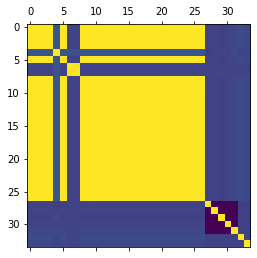

In [68]:
import matplotlib.pyplot as plt

plt.matshow(result.corr())
plt.show()

In [69]:
corrM = result.corr() 
  
corrM 

,open,high,low,close,volume,L1,RateofReturn,Return,MA100,MA200,...,S2,R3,S3,['Day_of_week']_0,['Day_of_week']_1,['Day_of_week']_2,['Day_of_week']_3,['Day_of_week']_4,['Day_of_week']_5,['Day_of_week']_6
open,1.000000,0.999997,0.999996,0.999994,0.079431,0.999998,-0.001482,-0.000189,0.999775,0.999530,...,0.999991,0.999983,0.999982,-0.004541,-0.001894,-0.015037,0.004755,0.013003,0.037960,0.016598
high,0.999997,1.000000,0.999994,0.999997,0.080369,0.999994,0.000050,0.001371,0.999771,0.999526,...,0.999986,0.999993,0.999975,-0.004543,-0.001903,-0.015037,0.004731,0.013034,0.038005,0.016593
low,0.999996,0.999994,1.000000,0.999997,0.078532,0.999994,-0.000012,0.001329,0.999772,0.999528,...,0.999998,0.999975,0.999993,-0.004558,-0.001870,-0.015031,0.004780,0.012971,0.037890,0.016592
close,0.999994,0.999997,0.999997,1.000000,0.079495,0.999992,0.001308,0.002675,0.999770,0.999525,...,0.999993,0.999986,0.999986,-0.004549,-0.001889,-0.015037,0.004755,0.013008,0.037952,0.016594
volume,0.079431,0.080369,0.078532,0.079495,1.000000,0.079251,0.066177,0.060568,0.076728,0.075713,...,0.077626,0.082230,0.076718,-0.019867,-0.006772,0.007370,-0.007351,0.026354,0.002394,-0.000674
L1,0.999998,0.999994,0.999994,0.999992,0.079251,1.000000,-0.002636,-0.001356,0.999777,0.999532,...,0.999989,0.999980,0.999980,-0.004535,-0.001895,-0.015046,0.004762,0.013001,0.037964,0.016589
RateofReturn,-0.001482,0.000050,-0.000012,0.001308,0.066177,-0.002636,1.000000,0.978341,-0.002322,-0.002394,...,0.000387,0.000970,0.000786,-0.002971,0.001503,0.002350,-0.002168,0.001435,-0.002475,0.001088
Return,-0.000189,0.001371,0.001329,0.002675,0.060568,-0.001356,0.978341,1.000000,-0.001052,-0.001131,...,0.001750,0.002294,0.002171,-0.003460,0.001572,0.002125,-0.001748,0.001692,-0.003003,0.001372
MA100,0.999775,0.999771,0.999772,0.999770,0.076728,0.999777,-0.002322,-0.001052,1.000000,0.999881,...,0.999768,0.999755,0.999761,-0.003790,-0.002181,-0.015428,0.004944,0.012719,0.038393,0.016349
MA200,0.999530,0.999526,0.999528,0.999525,0.075713,0.999532,-0.002394,-0.001131,0.999881,1.000000,...,0.999524,0.999510,0.999516,-0.003041,-0.002532,-0.015783,0.005115,0.012485,0.038810,0.016059


In [70]:
H_df1

,open,close,low,high,volume,L1,RateofReturn,Return,MA100,MA200,...,L10,P_Result,PP,R1,S1,R2,S2,R3,S3,Day_of_week
DateIndex,,,,,,,,,,,,,,,,,,,,,
2017-01-03 13:00:00+05:30,547.48,546.08,545.33,548.20,405278.0,547.48,-0.002557,-1.40,544.596667,544.596667,...,543.53,1,546.536667,547.743333,544.873333,549.406667,543.666667,550.613333,542.003333,1
2017-01-03 14:00:00+05:30,546.08,547.40,545.25,548.50,674454.0,546.08,0.002417,1.32,544.812308,544.812308,...,544.68,0,547.050000,548.850000,545.600000,550.300000,543.800000,552.100000,542.350000,1
2017-01-03 15:00:00+05:30,547.40,544.50,542.65,547.68,668628.0,547.40,-0.005298,-2.90,544.790000,544.790000,...,544.48,0,544.943333,547.236667,542.206667,549.973333,539.913333,552.266667,537.176667,1
2017-01-04 09:00:00+05:30,546.00,540.10,538.58,546.50,676790.0,544.50,-0.008081,-4.40,544.477333,544.477333,...,543.38,0,541.726667,544.873333,536.953333,549.646667,533.806667,552.793333,529.033333,2
2017-01-04 10:00:00+05:30,540.10,536.88,535.78,540.48,858796.0,540.10,-0.005962,-3.22,544.002500,544.002500,...,542.40,1,537.713333,539.646667,534.946667,542.413333,533.013333,544.346667,530.246667,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 10:00:00+05:30,1733.00,1726.95,1721.05,1738.40,1816302.0,1733.40,-0.003721,-6.45,1638.971500,1560.014000,...,1732.15,0,1728.800000,1736.550000,1719.200000,1746.150000,1711.450000,1753.900000,1701.850000,4
2020-06-26 11:00:00+05:30,1726.65,1721.70,1718.95,1730.85,1264810.0,1726.95,-0.003040,-5.25,1640.209500,1561.311500,...,1732.80,0,1723.833333,1728.716667,1716.816667,1735.733333,1711.933333,1740.616667,1704.916667,4
2020-06-26 12:00:00+05:30,1721.70,1719.80,1717.00,1727.90,1276732.0,1721.70,-0.001104,-1.90,1641.532500,1562.643500,...,1734.00,1,1721.566667,1726.133333,1715.233333,1732.466667,1710.666667,1737.033333,1704.333333,4


In [71]:
list(H_df1)

['open',
 'close',
 'low',
 'high',
 'volume',
 'L1',
 'RateofReturn',
 'Return',
 'MA100',
 'MA200',
 'MA50',
 'L2',
 'L3',
 'L4',
 'L5',
 'L6',
 'L7',
 'L8',
 'L9',
 'L10',
 'P_Result',
 'PP',
 'R1',
 'S1',
 'R2',
 'S2',
 'R3',
 'S3',
 'Day_of_week']

In [72]:
YY = H_df1['P_Result']

In [73]:
H_df2 = H_df1.copy()

In [74]:
H_df2 = H_df2.drop(['P_Result'], axis=1)

In [75]:
H_df2 = H_df2.drop(['Day_of_week'], axis=1)

In [76]:
H_df2 = normalize(H_df2)

In [77]:
X_train = H_df2.to_numpy()

In [78]:
seq_len = 6

In [79]:
x = []
y = []

In [80]:
for i in range(seq_len, len(X_train)):
    x.append(X_train[i-seq_len:i])
    y.append(YY[i])

In [81]:
X_train[1]

array([0.02983508, 0.03082168, 0.03078087, 0.03011429, 0.0278971 ,
       0.0297896 , 0.56793074, 0.53124171, 0.02516876, 0.02057461,
       0.02589096, 0.03088423, 0.03010235, 0.02859332, 0.02972705,
       0.02777235, 0.02691228, 0.02767852, 0.02853859, 0.02869497,
       0.03040954, 0.03049126, 0.0309849 , 0.03033291, 0.03074736,
       0.03054255, 0.03108414])

In [82]:
x

[array([[0.03093139, 0.0297896 , 0.03084458, 0.02988246, 0.01411844,
         0.03088423, 0.54407345, 0.51922227, 0.02497755, 0.02036767,
         0.02571137, 0.03010235, 0.02859332, 0.02972705, 0.02777235,
         0.02691228, 0.02767852, 0.02853859, 0.02869497, 0.0277958 ,
         0.03000621, 0.02964015, 0.03040589, 0.02965705, 0.03064047,
         0.0294409 , 0.03080451],
        [0.02983508, 0.03082168, 0.03078087, 0.03011429, 0.0278971 ,
         0.0297896 , 0.56793074, 0.53124171, 0.02516876, 0.02057461,
         0.02589096, 0.03088423, 0.03010235, 0.02859332, 0.02972705,
         0.02777235, 0.02691228, 0.02767852, 0.02853859, 0.02869497,
         0.03040954, 0.03049126, 0.0309849 , 0.03033291, 0.03074736,
         0.03054255, 0.03108414],
        [0.03086874, 0.02855423, 0.02871023, 0.02948063, 0.02759887,
         0.03082168, 0.53092949, 0.5125939 , 0.02514898, 0.0205532 ,
         0.02587238, 0.0297896 , 0.03088423, 0.03010235, 0.02859332,
         0.02972705, 0.02777235, 0.